<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/EfficientNet_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet

元論文 >> EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks https://arxiv.org/abs/1905.11946


EfficientNetは主に３つのモジュールでこんな感じ。

1. stemモジュール
- Conv(channel = 32, kernel_size = 3, padding = 1, stride = 2)
- BatchNormalization
- Swish activation

2. Blockモジュール

ブロックの中身は

<img src="https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/images/efficientNet_block.png?raw=1" width=400>

でEfficientNetB0, B1などでそれぞれパラメータが違う。各ブロックは繰り返し数(repeat)が設定されている。

| Block | Kernel_size | repeats | filters_in | filters_out | expand_ratio | stride | se_ratio |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Block 1 | 3 | 1 | 32 | 16 | 1 | 1 | 0.25 |
| Block 2 | 3 | 2 | 16 | 24 | 6 | 2 | 0.25 |
| Block 3 | 5 | 2 | 24 | 40 | 6 | 2 | 0.25 |
| Block 4 | 3 | 3 | 40 | 80 | 6 | 2 | 0.25 |
| Block 5 | 5 | 3 | 80 | 112 | 6 | 1 | 0.25 |
| Block 6 | 5 | 4 | 112 | 192 | 6 | 2 | 0.25 |
| Block 7 | 3 | 1 | 192 | 320 | 6 | 1 | 0.25 |

3. Outputモジュール

最後は以下の操作をして、クラス予測を出力する。
- Conv(channel = 1280, kernel_size = 1, padding = 0)
- BatchNormalization
- Swish activation
- Global Average Pooling
- BatchNormalization
- Dropout
- Fully Connected (class number)
- Softmax

実装は keras実装 https://github.com/keras-team/keras-applications/blob/master/keras_applications/efficientnet.py を参照した




# torchvision

In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import models

# def get_model(out_dim, dropout=0.5, pretrained=True):
#     model = mobilenet_v2(pretrained=True)
#     del model.fc
    
#     model.fc = nn.Sequential(
#         nn.Linear(1280, out_dim),
#     )

#     return model

# scratch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

class EfficientNet(nn.Module):
    def __init__(self, out_dim, block_type='B0'):
        super(EfficientNet, self).__init__()

        EFFICIENTNET_CONFIG = {
            'B0' : {'WIDTH_COEFFICIENT' : 1, 'DEPTH_COEFFICIENT' : 1, 'DROPOUT_RATIO' : 0.2, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B1' : {'WIDTH_COEFFICIENT' : 1, 'DEPTH_COEFFICIENT' : 1.1, 'DROPOUT_RATIO' : 0.2, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B2' : {'WIDTH_COEFFICIENT' : 1.1, 'DEPTH_COEFFICIENT' : 1.2, 'DROPOUT_RATIO' : 0.3, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B3' : {'WIDTH_COEFFICIENT' : 1.2, 'DEPTH_COEFFICIENT' : 1.4, 'DROPOUT_RATIO' : 0.3, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B4' : {'WIDTH_COEFFICIENT' : 1.2, 'DEPTH_COEFFICIENT' : 1.4, 'DROPOUT_RATIO' : 0.3, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B5' : {'WIDTH_COEFFICIENT' : 1.6, 'DEPTH_COEFFICIENT' : 2.2, 'DROPOUT_RATIO' : 0.4, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B6' : {'WIDTH_COEFFICIENT' : 1.8, 'DEPTH_COEFFICIENT' : 2.6, 'DROPOUT_RATIO' : 0.5, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2},
            'B7' : {'WIDTH_COEFFICIENT' : 2.0, 'DEPTH_COEFFICIENT' : 3.1, 'DROPOUT_RATIO' : 0.5, 'DEPTH_DIVISOR' : 8, 'DROP_CONNECT_RATIO' : 0.2}
        }

        width_coefficient = EFFICIENTNET_CONFIG[block_type]['WIDTH_COEFFICIENT']
        depth_coefficient = EFFICIENTNET_CONFIG[block_type]['DEPTH_COEFFICIENT']
        dropout_ratio = EFFICIENTNET_CONFIG[block_type]['DROPOUT_RATIO']
        depth_divisor = EFFICIENTNET_CONFIG[block_type]['DEPTH_DIVISOR']
        drop_connect_rate = EFFICIENTNET_CONFIG[block_type]['DROP_CONNECT_RATIO']

        DEFAULT_BLOCKS_ARGS = [
            # block 1
            {'kernel_size': 3, 'repeats': 1, 'filters_in': 32, 'filters_out': 16,
            'expand_ratio': 1, 'id_skip': True, 'stride': 1, 'se_ratio': 0.25},
            # block 2
            {'kernel_size': 3, 'repeats': 2, 'filters_in': 16, 'filters_out': 24,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 3
            {'kernel_size': 5, 'repeats': 2, 'filters_in': 24, 'filters_out': 40,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 4
            {'kernel_size': 3, 'repeats': 3, 'filters_in': 40, 'filters_out': 80,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 5
            {'kernel_size': 5, 'repeats': 3, 'filters_in': 80, 'filters_out': 112,
            'expand_ratio': 6, 'id_skip': True, 'stride': 1, 'se_ratio': 0.25},
            # block 6
            {'kernel_size': 5, 'repeats': 4, 'filters_in': 112, 'filters_out': 192,
            'expand_ratio': 6, 'id_skip': True, 'stride': 2, 'se_ratio': 0.25},
            # block 7
            {'kernel_size': 3, 'repeats': 1, 'filters_in': 192, 'filters_out': 320,
            'expand_ratio': 6, 'id_skip': True, 'stride': 1, 'se_ratio': 0.25}
        ]

        def round_filters(filters, divisor=depth_divisor):
            """Round number of filters based on depth multiplier."""
            filters *= width_coefficient
            new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
            # Make sure that round down does not go down by more than 10%.
            if new_filters < 0.9 * filters:
                new_filters += divisor
            return int(new_filters)

        def round_repeats(repeats):
            """Round number of repeats based on depth multiplier."""
            return int(np.ceil(depth_coefficient * repeats))
                    

        class Block(nn.Module):
            def __init__(self, activation_fn=Swish(), drop_rate=0.,
                filters_in=32, filters_out=16, kernel_size=3, stride=1,
                expand_ratio=1, se_ratio=0., id_skip=True):
                super(Block, self).__init__()

                # Expansion phase
                filters = filters_in * expand_ratio

                if expand_ratio != 1:
                    self.expansion = nn.Sequential(
                        nn.Conv2d(filters_in, filters, kernel_size=1, padding=0, bias=False),
                        nn.BatchNorm2d(filters),
                        activation_fn
                    )

                # Depthwise Convolution
                conv_pad = kernel_size // 2
                
                self.DW_conv = nn.Sequential(
                    nn.Conv2d(filters, filters, kernel_size, stride=stride, padding=conv_pad, bias=False, groups=1),
                    nn.BatchNorm2d(filters),
                    activation_fn
                )


                # Squeeze and Excitation phase
                if 0 < se_ratio <= 1:
                    filters_se = max(1, int(filters_in * se_ratio))

                    self.SE_phase = nn.Sequential(
                        nn.AdaptiveMaxPool2d((1, 1)),
                        Reshape(c=filters, h=1, w=1),
                        nn.Conv2d(filters, filters_se, kernel_size=1, padding=0),
                        activation_fn,
                        nn.Conv2d(filters_se, filters, kernel_size=1, padding=0),
                        nn.Sigmoid()
                    )
                    

                # Output phase
                self.output_phase = torch.nn.Sequential(
                    nn.Conv2d(filters, filters_out, kernel_size=1, padding=0, bias=False),
                    nn.BatchNorm2d(filters_out)
                )


                # 
                self.last_add = False
                if (id_skip is True and stride == 1 and filters_in == filters_out):
                    if drop_rate > 0:
                        self.output_phase_Dropout = torch.nn.Dropout2d(p=drop_rate)

                    self.last_add = True

                
            def forward(self, input_x):
                # expansion phase
                if hasattr(self, 'expansion'):
                    x = self.expansion(input_x)
                else:
                    x = input_x

                x = self.DW_conv(x)

                # Squeeze and Excitation phase
                if hasattr(self, 'SE_phase'):
                    x_SE_phase = self.SE_phase(x)
                    x = x * x_SE_phase

                # Output phase
                x = self.output_phase(x)

                if hasattr(self, 'output_phase_Dropout'):
                    x = self.output_phase_Dropout(x)

                if self.last_add:
                    x = x + input_x

                return x

        # stem
        self.stem = torch.nn.Sequential(
            nn.Conv2d(3, round_filters(32), kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(round_filters(32)),
            Swish()
        )
        
        # block
        module = []

        b = 0
        block_Num = float(sum(args['repeats'] for args in DEFAULT_BLOCKS_ARGS))

        for (i, args) in enumerate(DEFAULT_BLOCKS_ARGS):
            assert args['repeats'] > 0
            # Update block input and output filters based on depth multiplier.
            args['filters_in'] = round_filters(args['filters_in'])
            args['filters_out'] = round_filters(args['filters_out'])

            for j in range(round_repeats(args.pop('repeats'))):
                # The first block needs to take care of stride and filter size increase.
                if j > 0:
                    args['stride'] = 1
                    args['filters_in'] = args['filters_out']

                module.append(
                    Block(activation_fn=Swish(), drop_rate=drop_connect_rate * b / block_Num, **args))
                b += 1

        self.block = nn.Sequential(*module)


        # top

        
        self.top = nn.Sequential(
            nn.Conv2d(DEFAULT_BLOCKS_ARGS[-1]['filters_out'], round_filters(1280), kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(round_filters(1280)),
            Swish()
        )

        if dropout_ratio > 0:
            self.top = nn.Sequential(
                nn.Conv2d(DEFAULT_BLOCKS_ARGS[-1]['filters_out'], round_filters(1280), kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(round_filters(1280)),
                Swish(),
                nn.AdaptiveMaxPool2d((1, 1)),
                nn.Dropout2d(p=dropout_ratio),
                Flatten(),
                nn.Linear(round_filters(1280), out_dim)
            )
        else:
            self.top = nn.Sequential(
                nn.Conv2d(DEFAULT_BLOCKS_ARGS[-1]['filters_out'], round_filters(1280), kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(round_filters(1280)),
                Swish(),
                nn.AdaptiveMaxPool2d((1, 1)),
                Flatten(),
                nn.Linear(round_filters(1280), out_dim)
            )

        
    def forward(self, x):
        x = self.stem(x)
        x = self.block(x)
        x = self.top(x)
        return x

In [4]:
!pip install -q --upgrade albumentations==0.5.1

# Import

In [5]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [6]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [7]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Files already downloaded and verified


In [8]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [11]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = EfficientNet(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:2.6984 acc:0.1025  [val]loss:2.3107 acc:0.1000  [time]total:156.61sec tra:130.46sec val:26.15sec
fold:1 epoch:2/30 [tra]loss:2.5016 acc:0.1098  [val]loss:2.3121 acc:0.1013  [time]total:156.57sec tra:130.39sec val:26.18sec
fold:1 epoch:3/30 [tra]loss:2.4739 acc:0.1111  [val]loss:3.0865 acc:0.1164  [time]total:156.63sec tra:130.47sec val:26.16sec
fold:1 epoch:4/30 [tra]loss:2.4107 acc:0.1091  [val]loss:2.6866 acc:0.1405  [time]total:156.54sec tra:130.12sec val:26.42sec
fold:1 epoch:5/30 [tra]loss:2.3638 acc:0.1335  [val]loss:2.2902 acc:0.1423  [time]total:156.88sec tra:130.61sec val:26.28sec
fold:1 epoch:6/30 [tra]loss:2.2291 acc:0.1702  [val]loss:2.3865 acc:0.1792  [time]total:157.42sec tra:130.88sec val:26.54sec
fold:1 epoch:7/30 [tra]loss:2.1142 acc:0.1968  [val]loss:2.4340 acc:0.1852  [time]total:156.84sec tra:130.31sec val:26.53sec
fold:1 epoch:8/30 [tra]loss:2.0820 acc:0.2016  [val]loss:2.7553 acc:0.201

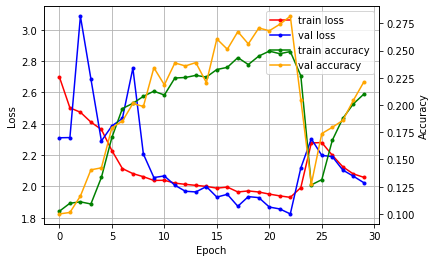

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:2.6253 acc:0.1012  [val]loss:4.6713 acc:0.1095  [time]total:155.65sec tra:129.45sec val:26.20sec
fold:2 epoch:2/30 [tra]loss:2.6519 acc:0.0991  [val]loss:3.0107 acc:0.0992  [time]total:156.28sec tra:130.09sec val:26.19sec
fold:2 epoch:3/30 [tra]loss:2.4459 acc:0.1086  [val]loss:16.1168 acc:0.0999  [time]total:156.40sec tra:130.14sec val:26.26sec
fold:2 epoch:4/30 [tra]loss:2.5310 acc:0.1062  [val]loss:2.3177 acc:0.1164  [time]total:157.33sec tra:131.00sec val:26.33sec
fold:2 epoch:5/30 [tra]loss:2.4262 acc:0.1110  [val]loss:2.4037 acc:0.1012  [time]total:157.37sec tra:131.18sec val:26.19sec
fold:2 epoch:6/30 [tra]loss:2.4130 acc:0.1077  [val]loss:2.3581 acc:0.1297  [time]total:157.18sec tra:130.90sec val:26.28sec
fold:2 epoch:7/30 [tra]loss:2.3308 acc:0.1270  [val]loss:3.6154 acc:0.1599  [time]total:156.71sec tra:130.40sec val:26.30sec
fold:2 epoch:8/30 [tra]loss:2.2393 acc:0.1648  [val]loss:2.2510 acc:0.15

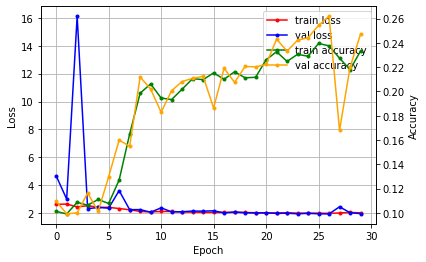

all folds score
total loss:1.994330, accuracy:0.234100
fold1/2 loss:2.024102, accuracy:0.221080
fold2/2 loss:1.964558, accuracy:0.247120

cross table


pred,0,1,3,4,5,6,7,8,9
label,,,,,,,,,
0,1828,12,341,54,5,220,69,1270,1201
1,240,36,407,21,1,367,62,1154,2712
2,384,21,739,1051,13,1309,187,368,928
3,106,29,1233,202,45,1284,285,308,1508
4,158,30,598,1368,34,1692,159,327,634
5,81,22,1317,300,6,1397,288,267,1322
6,49,58,664,1051,63,2285,226,97,507
7,61,24,1266,396,7,1431,300,229,1286
8,1574,3,179,4,5,89,22,1901,1223


In [12]:
train_models, train_model_paths = train()

# Test

In [13]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.2472 (2472 / 10000)


pred,0,1,3,4,5,6,7,8,9
label,,,,,,,,,
0,374,6,52,11,0,42,11,292,212
1,24,46,65,3,0,49,21,250,542
2,81,6,134,216,1,252,47,84,179
3,19,21,233,46,1,266,68,65,281
4,30,5,90,305,1,345,25,72,127
5,16,21,230,55,1,293,75,63,246
6,5,23,108,218,4,480,48,22,92
7,13,15,258,59,0,264,66,56,269
8,281,4,40,1,0,20,3,427,224
